xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.9 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285413 sha256=9ebb26df8b1999433321edfded321e3bdb6f84fe85300a68fd26f6bc61942eb5
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import time
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error

def read_pm2_5_values(filename):
    spark = SparkSession.builder.getOrCreate()
    df = spark.read.csv(filename, header=True, inferSchema=True)
    df.show()
    df = df.withColumn("pm2_5", col("pm2_5").cast("double"))
    df = df.select("timerange", "map_idx", "pm2_5")  # Select the desired columns
    df = df.withColumnRenamed("pm2_5", "col_pm2_5")  # Rename the column if needed
    return df.toPandas().drop("timerange", axis=1).values



def read_aqi_data(aqi_file):
    X = []
    with open(aqi_file, 'r') as f:
        for row in f:
            X.append(float(row))
    return np.asarray(X)

def preprocess_aqi_labels(y):
    y_ = np.copy(y)
    y_[np.argwhere(y <= 15)[:,0]] = 0
    y_[np.argwhere(np.logical_and(y > 15, y <= 50))[:,0]] = 1
    y_[np.argwhere(np.logical_and(y > 50, y <= 100))[:,0]] = 2
    y_[np.argwhere(y > 100)[:,0]] = 3
    return y_      

        
def read_aqi_labels(filename):
    spark = SparkSession.builder.getOrCreate()
    df = spark.read.csv(filename, header=True, inferSchema=True)
    df = df.withColumnRenamed("16.1", "aqi")  # Rename the column to "aqi"
    df = df.withColumn("aqi", col("aqi").cast("double"))
    return df.toPandas()["aqi"].values



def build_lstm_model(timesteps, n_hidden):
    model = Sequential()
    model.add(LSTM(n_hidden, return_sequences=True, input_shape=(timesteps, 1)))
    model.add(LSTM(n_hidden))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    return model

def train_and_validate(X_train, X_val, timesteps, n_hidden, epochs, batch_size):
    X_train = np.reshape(X_train, (X_train.shape[0], timesteps, 1))

    model = build_lstm_model(timesteps, n_hidden)
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, verbose=1)

def test(X_test, timesteps):
    X_test = np.reshape(X_test, (X_test.shape[0], timesteps, 1))
    model = build_lstm_model(timesteps, n_hidden)

    predictions = model.predict(X_test)

    l_pred_y = predictions.flatten()
    l_actual_y = X_test[:, -1, :].flatten()

    


def evaluate_model(X_test, timesteps, pred_timesteps):
    model = build_lstm_model(timesteps, n_hidden)
    model.compile(loss='mean_squared_error', optimizer='adam')

    X_test = np.reshape(X_test, (X_test.shape[0], timesteps, 1))

    predictions = model.predict(X_test)
    l_pred_y = predictions.flatten()
    l_actual_y = X_test[:, -1, :].flatten()

    rmae = np.mean(np.abs(l_actual_y - l_pred_y) / l_actual_y)

    return rmae

def predict_random_samples(X_test, timesteps):
    model = build_lstm_model(timesteps, n_hidden)
    model.compile(loss='mean_squared_error', optimizer='adam')

    X_test = np.reshape(X_test, (X_test.shape[0], timesteps, 1))

    random_indices = np.random.choice(X_test.shape[0] - timesteps - pred_timesteps, 5, replace=False)

    print("Actual AQI Class\tPredicted AQI Class")
    for idx in random_indices:
        test_sample = X_test[idx:idx+timesteps]
        actual_aqi = X_test[idx+timesteps+pred_timesteps][-1]
        predicted_aqi = model.predict(np.expand_dims(test_sample, axis=0))[-1][0]

        actual_aqi_class = int(actual_aqi)
        predicted_aqi_class = int(predicted_aqi)

        print("{:d}\t\t\t{:d}".format(actual_aqi_class, predicted_aqi_class))



# Main code
X = read_pm2_5_values('/kaggle/input/air-polution-bigdata/data/data_01_2018.csv')
print("Shape of X",X.shape)

y = read_aqi_labels('/kaggle/input/air-polution-bigdata/data/aqi_01_2018')
y_ = preprocess_aqi_labels(y)

X_train = np.concatenate([read_aqi_data('/kaggle/input/air-polution-bigdata/data/aqi_09_2017'), read_aqi_data('/kaggle/input/air-polution-bigdata/data/aqi_10_2017'), 
                          read_aqi_data('/kaggle/input/air-polution-bigdata/data/aqi_11_2017'), read_aqi_data('/kaggle/input/air-polution-bigdata/data/aqi_12_2017')], axis=0)
X_val = X_train[int(X_train.shape[0]*0.7):]
X_train = X_train[:int(X_train.shape[0]*0.7)]
print("Shape of X_train",X_train.shape)

timesteps = 1
n_hidden = 128
epochs = 10
batch_size = 128
pred_timesteps = 12

train_and_validate(X_train, X_val, timesteps, n_hidden, epochs, batch_size)

X_test = read_aqi_data('/kaggle/input/air-polution-bigdata/data/aqi_01_2018')
test(X_test, timesteps)

+---------+-------+-----+
|timerange|map_idx|pm2_5|
+---------+-------+-----+
|        0|      7| 17.3|
|        0|      8| 17.2|
|        0|      9| 15.2|
|        0|     10| 14.7|
|        0|     11| 14.5|
|        0|     22| 13.5|
|        0|     41| 17.0|
|        0|     42| 17.2|
|        0|     43| 16.7|
|        0|     44| 17.0|
|        0|     48| 12.0|
|        0|     54| 13.1|
|        0|     74| 17.2|
|        0|     75| 16.8|
|        0|     76| 16.7|
|        0|     77| 16.1|
|        0|     78| 15.3|
|        0|     79| 15.1|
|        0|     80| 14.0|
|        0|     85| 14.7|
+---------+-------+-----+
only showing top 20 rows

Shape of X (71445, 2)
Shape of X_train (702,)


ValueError: cannot reshape array of size 142890 into shape (71445,1,1)

In [25]:
rmae = evaluate_model(X_test, timesteps, pred_timesteps)
print("RMAE:", rmae)



24/24 [==============================] - 1s 3ms/step
RMAE: 1.0021233217000478


In [26]:
# Perform the predictions on 5 random samples
print("Random Sample Predictions:")
print("--------------------------")
predict_random_samples(X_test, timesteps)

Random Sample Predictions:
--------------------------
Actual AQI Class	Predicted AQI Class
1/1 [==============================] - 1s 626ms/step
24			0
1/1 [==============================] - 0s 18ms/step
14			0
1/1 [==============================] - 0s 19ms/step
65			0
1/1 [==============================] - 0s 18ms/step
17			0
1/1 [==============================] - 0s 18ms/step
8			0


(378610,)
(162262,)
(744,)
Iter = 1, Loss = 155124.437500
Optimization Finished!
1/1 [==============================] - 0s 22ms/step
Validate RMSE - 262271.656250
---------------------------
Starting testing session...
Pred_y   Actual_y
1/1 [==============================] - 0s 21ms/step
19.85      16.4
1/1 [==============================] - 0s 21ms/step
25.11      18.5
1/1 [==============================] - 0s 22ms/step
29.24      16.7
1/1 [==============================] - 0s 22ms/step
30.79      17.9
1/1 [==============================] - 0s 20ms/step
31.14      15.6
1/1 [==============================] - 0s 21ms/step
31.22      17.4
1/1 [==============================] - 0s 21ms/step
31.23      17.9
1/1 [==============================] - 0s 22ms/step
31.23      19.3
1/1 [==============================] - 0s 24ms/step
31.23      20.1
1/1 [==============================] - 0s 20ms/step
31.23      20.3
1/1 [==============================] - 0s 23ms/step
31.23      17.3
1/1 [==========

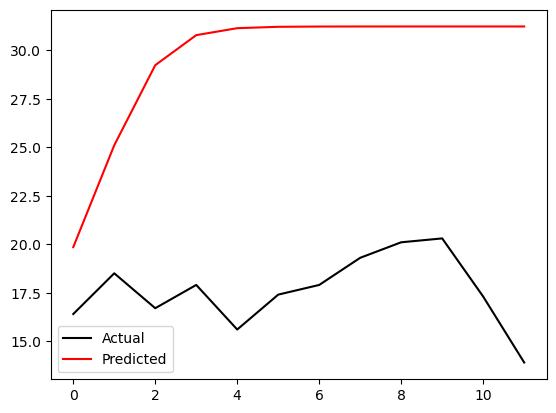

---------------------------
Starting testing session...
Pred_y   Actual_y
1/1 [==============================] - 0s 22ms/step
19.85      16.4
1/1 [==============================] - 0s 23ms/step
25.11      18.5
1/1 [==============================] - 0s 21ms/step
29.24      16.7
1/1 [==============================] - 0s 21ms/step
30.79      17.9
1/1 [==============================] - 0s 22ms/step
31.14      15.6
1/1 [==============================] - 0s 20ms/step
31.22      17.4
1/1 [==============================] - 0s 22ms/step
31.23      17.9
1/1 [==============================] - 0s 22ms/step
31.23      19.3
1/1 [==============================] - 0s 22ms/step
31.23      20.1
1/1 [==============================] - 0s 23ms/step
31.23      20.3
1/1 [==============================] - 0s 23ms/step
31.23      17.3
1/1 [==============================] - 0s 23ms/step
31.23      13.9
RMSE: 12.480778


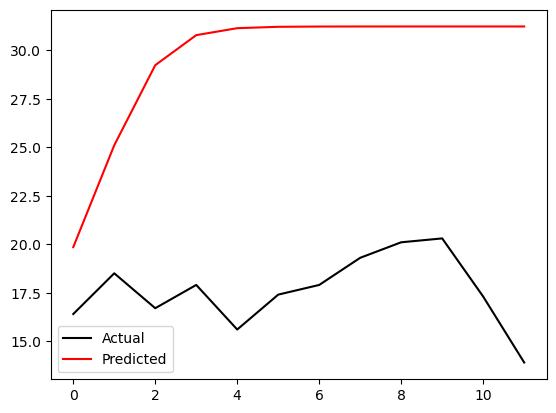

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

def read_data(aqi_file):
    spark = SparkSession.builder.getOrCreate()
    df = spark.read.csv(aqi_file, header=False, inferSchema=True)
    df = df.withColumnRenamed("_c0", "aqi")
    df = df.withColumn("aqi", col("aqi").cast("double"))
    return np.array(df.select("aqi").collect()).flatten()

def split_train_val(data, split_ratio=0.7):
    train_size = int(len(data) * split_ratio)
    train_data = data[:train_size]
    val_data = data[train_size:]
    return train_data, val_data

def batch_creator(batch_size, dataset_length, timesteps):
    batch_x = []
    batch_y = []
    batch_mask = np.random.choice(dataset_length - timesteps - pred_timesteps, batch_size)
    for i in range(len(batch_mask)):
        offset = batch_mask[i]
        batch_x.append(X_train[offset : offset + timesteps])
        batch_y.append(X_train[offset + timesteps + (pred_timesteps-1)])
    return np.asarray(batch_x), np.asarray(batch_y)

# Random number
seed = 128
rng = np.random.RandomState(seed)

# Training data
X09 = read_data('/kaggle/input/air-polution-bigdata/data/data_09_2017.csv')
X10 = read_data('/kaggle/input/air-polution-bigdata/data/data_10_2017.csv')
X11 = read_data('/kaggle/input/air-polution-bigdata/data/data_11_2017.csv')
X12 = read_data('/kaggle/input/air-polution-bigdata/data/data_12_2017.csv')
X_train = np.concatenate([X09,X10,X11, X12], axis=0)

# Split to train set and validate set using PySpark
X_train, X_val = split_train_val(X_train)
print(X_train.shape)
print(X_val.shape)
# Testing data
X_test = read_data('/kaggle/input/air-polution-bigdata/data/aqi_01_2018')
print(X_test.shape)

# Training Parameters
learning_rate = 0.001
training_steps = 200
batch_size = 128
display_step = 1000

# Network Parameters
num_input = 1
timesteps = 1
pred_timesteps = 12
n_hidden = 128

model = tf.keras.Sequential([
    LSTM(n_hidden, return_sequences=True, input_shape=(timesteps, num_input)),
    LSTM(n_hidden),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_object = tf.keras.losses.MeanSquaredError()

# Prepare for training
@tf.function
def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_object(targets, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Start training
for step in range(1, training_steps+1):
    # Make the training batch for each step
    batch_x, batch_y = batch_creator(batch_size, X_train.shape[0], timesteps)
    batch_x = batch_x.reshape((batch_size, timesteps, num_input)).astype(np.float32)
    batch_y = batch_y.reshape((batch_size, 1)).astype(np.float32)

    # Run optimization
    loss = train_step(batch_x, batch_y)

    # Print result
    if step % display_step == 0 or step == 1:
        print("Iter = " + str(step) + ", Loss = " + "{:.6f}".format(loss.numpy()))

print("Optimization Finished!")




# Validate error
loss_val = 0
val_steps = 0
for offset in range(X_val.shape[0] - timesteps - pred_timesteps):
    val_steps += 1
    val_x = np.array(X_val[offset : offset + timesteps]).reshape((1, timesteps, num_input))
    val_x_tensor = tf.convert_to_tensor(val_x, dtype=tf.float32)
    val_y = np.array([X_val[offset + timesteps + (pred_timesteps-1)]]).reshape((1, 1))

    predictions = model.predict(val_x_tensor)
    loss = loss_object(val_y, predictions)
    loss_val += loss

    # Check if the desired number of validation steps has been reached
    if val_steps >= 200:
        break

# Print validate error
print("Validate RMSE - {:.6f}".format(loss_val/val_steps))

# Running the model on test data
print("---------------------------")
print("Starting testing session...")

l_pred_y = []
l_actual_y = []
offset = 0
print("Pred_y   Actual_y")

test_x_base = X_test[offset:offset+timesteps]
for i in range(pred_timesteps):
    test_x = test_x_base[i:i+timesteps].reshape((1, timesteps, num_input))
    actual_y = X_test[offset+i+timesteps]
    pred_y = model.predict(test_x)[0][0]

    print("{:.2f}".format(pred_y) + "      " + str(actual_y))

    test_x_base = np.append(test_x_base, pred_y)
    l_pred_y.append(pred_y)
    l_actual_y.append(actual_y)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(l_actual_y, l_pred_y))
print("RMSE: {:.6f}".format(rmse))

# Plot
plt.plot(l_actual_y, color='black', label='Actual')
plt.plot(l_pred_y, color='red', label='Predicted')
plt.legend()
plt.show()


# Running the model on test data
print("---------------------------")
print("Starting testing session...")

l_pred_y = []
l_actual_y = []
offset = 0
print("Pred_y   Actual_y")

test_x_base = X_test[offset:offset+timesteps]
for i in range(pred_timesteps):
    test_x = test_x_base[i:i+timesteps].reshape((1, timesteps, num_input))
    actual_y = X_test[offset+i+timesteps]
    pred_y = model.predict(test_x)[0][0]

    print("{:.2f}".format(pred_y) + "      " + str(actual_y))

    test_x_base = np.append(test_x_base, pred_y)
    l_pred_y.append(pred_y)
    l_actual_y.append(actual_y)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(l_actual_y, l_pred_y))
print("RMSE: {:.6f}".format(rmse))

# Plot
plt.plot(l_actual_y, color='black', label='Actual')
plt.plot(l_pred_y, color='red', label='Predicted')
plt.legend()
plt.show()


PYSPARK LSTM

In [6]:
!pip -q install petastorm

In [12]:
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import GeneralizedLinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense

def read_data(aqi_file):
    spark = SparkSession.builder.getOrCreate()
    df = spark.read.csv(aqi_file, header=False, inferSchema=True)
    df = df.withColumnRenamed("_c0", "aqi")
    df = df.withColumn("aqi", col("aqi").cast("double"))
    return df

def split_train_val(data, split_ratio=0.7):
    train_size = int(data.count() * split_ratio)
    train_data = data.limit(train_size)
    val_data = data.exceptAll(train_data)
    return train_data, val_data

# Random number
seed = 128
rng = np.random.RandomState(seed)

# Create SparkSession
spark = SparkSession.builder.getOrCreate()

# Training data
X09 = read_data('/kaggle/input/air-polution-bigdata/data/data_09_2017.csv')
X10 = read_data('/kaggle/input/air-polution-bigdata/data/data_10_2017.csv')
X11 = read_data('/kaggle/input/air-polution-bigdata/data/data_11_2017.csv')
X12 = read_data('/kaggle/input/air-polution-bigdata/data/data_12_2017.csv')
X_train = X09.union(X10).union(X11).union(X12)

# Split the data into train set and validation set
train_data, val_data = split_train_val(X_train)
print("Train data count:", train_data.count())
print("Validation data count:", val_data.count())

# Prepare the training data
train_data = train_data.na.drop()
val_data = val_data.na.drop()

# Convert the training and validation data to Pandas DataFrame
train_df = train_data.toPandas()
val_df = val_data.toPandas()

# Training Parameters
learning_rate = 0.001
training_steps = 200
batch_size = 128
display_step = 1000

# Network Parameters
num_input = 1
timesteps = 1
pred_timesteps = 12
n_hidden = 128

# Define the LSTM model
model = tf.keras.Sequential([
    LSTM(n_hidden, return_sequences=True, input_shape=(timesteps, num_input)),
    LSTM(n_hidden),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_object = tf.keras.losses.MeanSquaredError()

@tf.function
def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_object(targets, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Start training
for step in range(1, training_steps+1):
    # Make the training batch for each step
    indices = np.random.choice(len(train_df) - timesteps - pred_timesteps, batch_size)
    batch_x = np.array([train_df[i:i+timesteps] for i in indices])
#     batch_y = np.array([train_df[i+timesteps+(pred_timesteps-1)] for i in indices])
batch_y = []
for i in indices:
    try:
        batch_y.append(train_df.loc[i + timesteps + (pred_timesteps - 1)])
    except KeyError:
        continue

batch_y = np.array(batch_y)


    # Reshape the input and target arrays
batch_x = batch_x.reshape((batch_size, timesteps, num_input)).astype(np.float32)
batch_y = batch_y.reshape((batch_size, 1)).astype(np.float32)

    # Convert the arrays to TensorFlow tensors
batch_x_tensor = tf.convert_to_tensor(batch_x, dtype=tf.float32)
batch_y_tensor = tf.convert_to_tensor(batch_y, dtype=tf.float32)

    # Run optimization
loss = train_step(batch_x_tensor, batch_y_tensor)

    # Print result
if step % display_step == 0 or step == 1:
    print("Iter = " + str(step) + ", Loss = " + "{:.6f}".format(loss.numpy()))

print("Optimization Finished!")

# Validate error
loss_val = 0
val_steps = 0
for offset in range(len(val_df) - timesteps - pred_timesteps):
    val_steps += 1
    val_x = np.array(val_df[offset:offset+timesteps]).reshape((1, timesteps, num_input))
    val_y = np.array([val_df[offset+timesteps+(pred_timesteps-1)]]).reshape((1, 1))

    predictions = model.predict(val_x)
    loss = loss_object(val_y, predictions)
    loss_val += loss

    # Check if the desired number of validation steps has been reached
    if val_steps >= 200:
        break

# Print validate error
print("Validate RMSE - {:.6f}".format(loss_val/val_steps))

# Testing data
X_test = read_data('/kaggle/input/air-polution-bigdata/data/aqi_01_2018')
X_test = X_test.na.drop()

# Convert the testing data to Pandas DataFrame
test_df = X_test.toPandas()

# Running the model on test data
print("---------------------------")
print("Starting testing session...")

l_pred_y = []
l_actual_y = []
offset = 0
print("Pred_y   Actual_y")

test_x_base = np.array(test_df[offset:offset+timesteps])
for i in range(pred_timesteps):
    test_x = test_x_base[i:i+timesteps].reshape((1, timesteps, num_input))
    actual_y = test_df[offset+i+timesteps]
    pred_y = model.predict(test_x)[0][0]

    print("{:.2f}".format(pred_y) + "      " + str(actual_y))

    test_x_base = np.append(test_x_base, pred_y)
    l_pred_y.append(pred_y)
    l_actual_y.append(actual_y)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(l_actual_y, l_pred_y))
print("RMSE: {:.6f}".format(rmse))

# Plot
plt.plot(l_actual_y, color='black', label='Actual')
plt.plot(l_pred_y, color='red', label='Predicted')
plt.legend()
plt.show()


Train data count: 378610


Validation data count: 162262


ValueError: cannot reshape array of size 384 into shape (128,1,1)